## Modelo3 CNN

### CNN

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv('../dataset/data/sample_4M_cod.csv', dtype='int64')

In [2]:
# Asignar la columna de etiquetas a AttackCod
y = df['AttackCod'].values

NIDS_features=['L4_DST_PORT', 'L7_PROTO','IN_BYTES','IN_PKTS','OUT_BYTES','OUT_PKTS',
                'CLIENT_TCP_FLAGS','FLOW_DURATION_MILLISECONDS','DURATION_IN','DURATION_OUT','MIN_TTL',
                'MAX_TTL','LONGEST_FLOW_PKT','SHORTEST_FLOW_PKT','MIN_IP_PKT_LEN','MAX_IP_PKT_LEN',
               'SRC_TO_DST_SECOND_BYTES','SRC_TO_DST_AVG_THROUGHPUT','DST_TO_SRC_AVG_THROUGHPUT',
               'NUM_PKTS_UP_TO_128_BYTES','TCP_WIN_MAX_IN','TCP_WIN_MAX_OUT']

X = df[NIDS_features]

In [3]:
# Escalamos solo las características (X) y no las etiquetas (y)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [4]:
# Dividir datos
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape,X_test.shape)


(2800000, 22) (600000, 22)


In [5]:
# Cambiar la forma de los datos para que sean compatibles con la CNN
# Asumiendo que X_train tiene una forma (n_samples, n_features)
# Lo cambiamos a (n_samples, n_features, 1) para que sea tratado como una imagen de 1D con múltiples canales
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Visualizar el modelo en forma de gráfico y guardarlo en un archivo
plot_model(model, to_file='modelCNN_rfe_2do.png', show_shapes=True, show_layer_names=True)

# Resumen del modelo
model.summary()

# Definir el callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Registrar el tiempo de inicio
start_time = time.time()

# Entrenar modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=192, callbacks=[early_stopping])
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=200)

# Calcular el tiempo transcurrido en minutos
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print("Tiempo de entrenamiento (minutos):", elapsed_time_minutes)

### Metricas

In [7]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Realiza predicciones en los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convierte las probabilidades en clases predichas (usando un umbral de 0.5)

# Calcula la precisión, el recall y el F1-score para la clasificación binaria
precision = precision_score(y_test, y_pred_classes, average='binary')
recall = recall_score(y_test, y_pred_classes, average='binary')
f1 = f1_score(y_test, y_pred_classes, average='binary')
accuracy = accuracy_score(y_test, y_pred_classes)


print("Exactitud:", accuracy)
print("Sensibilidad:", recall)
print("Precisión:", precision)
print("F1-score:", f1)

18750/18750 [==============================] - 24s 1ms/step
Exactitud: 0.9987533333333334
Sensibilidad: 0.9985494391164583
Precisión: 0.9989558382983834
F1-score: 0.9987525973657791


### Guardar modelos keras

In [13]:
model.save('models_keras/cnn_rfe_2do.keras')


In [14]:
import pickle
# Guardar el historial de entrenamiento en un archivo(diccionario)
with open('models_keras/historycnn_rfe_2do.pkl', 'wb') as file:
    pickle.dump(history.history, file, protocol=pickle.HIGHEST_PROTOCOL)    

##### cargar

In [ ]:
from keras.models import load_model
# Cargar el modelo desde un archivo en formato nativo de Keras
model = load_model('models_keras/cnn_.keras')

In [ ]:
import pickle
# Cargar el historial de entrenamiento desde un archivo
with open('models_keras/historycnn_.pkl', 'rb') as file:
   history = pickle.load(file)

### AUC

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcular el AUC
auc = roc_auc_score(y_test, y_pred)

El Area bajo la curva(AUC) es: 0.9999611159052975


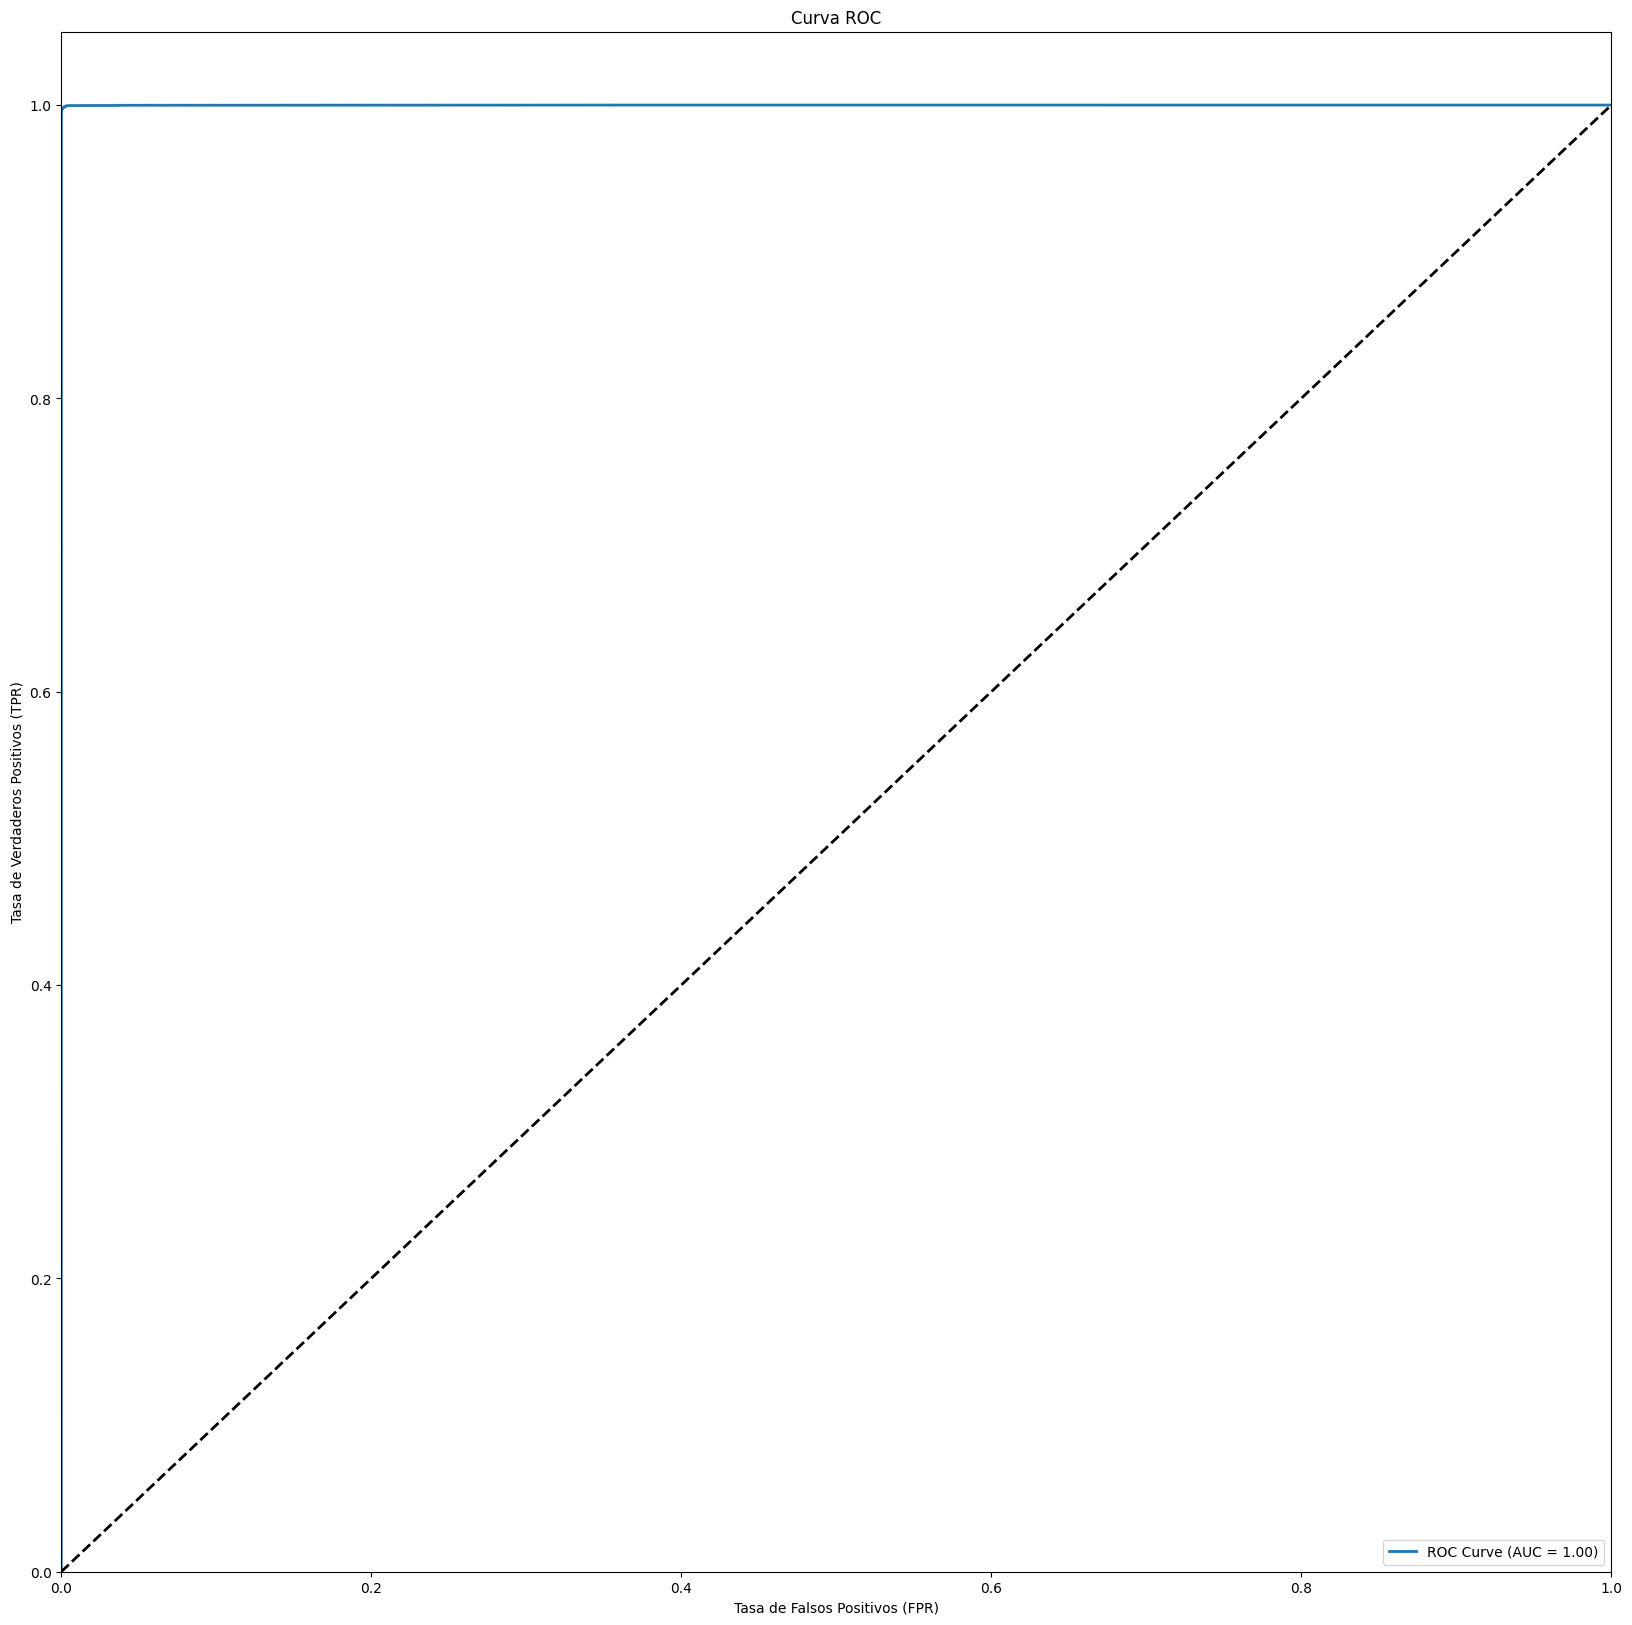

In [34]:
# Gráfica de la curva ROC
plt.figure(figsize=(20, 20))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")

#auc_crv = auc(fpr, tpr)
print(f"El Area bajo la curva(AUC) es: {auc}")
# Mostrar la gráfica de la curva ROC
plt.show()

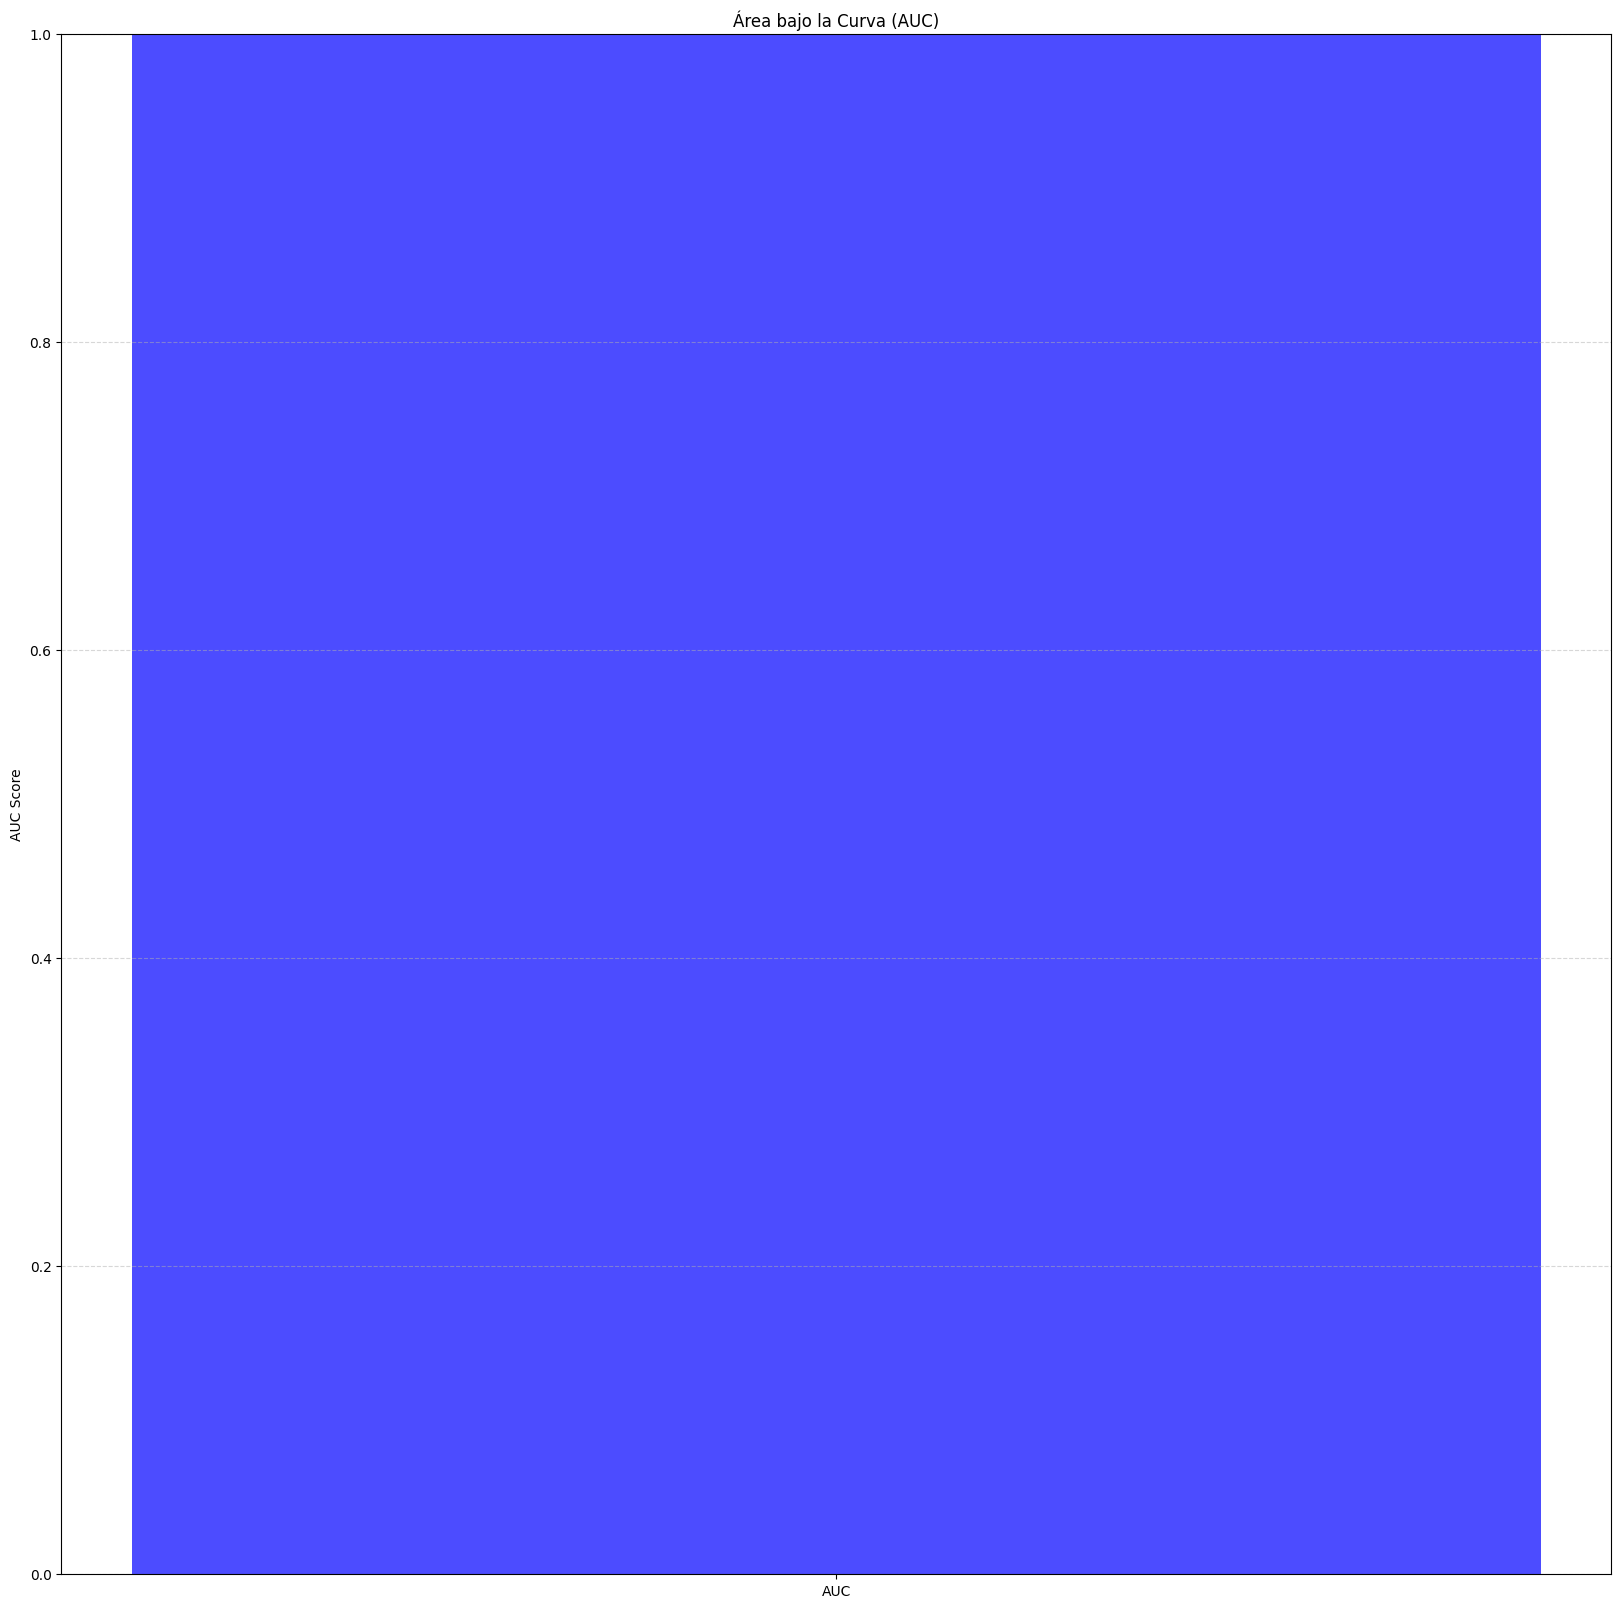

In [35]:
# Gráfica del AUC
plt.figure(figsize=(20, 20))
plt.bar(['AUC'], [auc], color='b', alpha=0.7)
plt.ylim([0.0, 1.0])
plt.ylabel('AUC Score')
plt.title('Área bajo la Curva (AUC)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar la gráfica del AUC
plt.show()

In [12]:
# Evaluar el modelo en los conjuntos de datos
train_metrics = model.evaluate(X_train, y_train, verbose=0)
val_metrics = model.evaluate(X_val, y_val, verbose=0)
test_metrics = model.evaluate(X_test, y_test, verbose=0)

# Imprimir las métricas
metric_names = ['loss', 'accuracy', 'recall', 'precision', 'f1']
print("Metricas Datos Entrenamiento:")
for name, val in zip(metric_names, train_metrics):
    print(f"{name}: {val}")

print("\nMetricas Datos Validación:")
for name, val in zip(metric_names, val_metrics):
    print(f"{name}: {val}")

print("\nMetricas datos de prueba:")
for name, val in zip(metric_names, test_metrics):
    print(f"{name}: {val}")

Metricas Datos Entrenamiento:
loss: 0.004441422875970602
accuracy: 0.9988896250724792

Metricas Datos Validación:
loss: 0.0043525430373847485
accuracy: 0.9989533424377441

Metricas datos de prueba:
loss: 0.004822136834263802
accuracy: 0.9987533092498779


### Graficar Curvas Aprendizaje Modelo en memoria (no cargado)

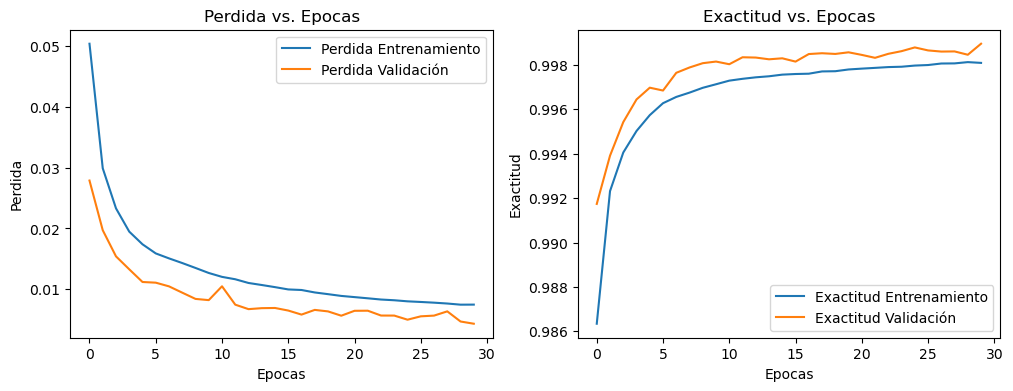

In [9]:
# Gráfico de la pérdida y la precisión en el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Perdida Validación')
plt.title('Perdida vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Exactitud Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Exactitud Validación')
plt.title('Exactitud vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Exactitud')
plt.legend()

plt.show()



### Cargar diccionario de historia con pickle y graficar curvas de aprendizaje

In [ ]:
# Gráfico de la pérdida y la precisión en el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Perdida Entrenamiento')
plt.plot(history['val_loss'], label='Perdida Validación')
plt.title('Perdida vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Exactitud Entrenamiento')
plt.plot(history['val_accuracy'], label='Exactitud Validación')
plt.title('Exactitud vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Exactitud')
plt.legend()

plt.show()

### Matriz

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Hacer predicciones
predicciones = model.predict(X_test)  # X_val es el conjunto de validación/prueba

# En un problema de clasificación binaria, normalmente se redondea la probabilidad a 0 o 1
# Esto es asumiendo que el modelo produce una salida de probabilidad para la clase positiva
predicciones_etiquetas = (predicciones > 0.5).astype(int)

# Generar la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones_etiquetas)

# Imprimir la matriz de confusión
print(matriz_confusion)

18750/18750 [==============================] - 25s 1ms/step
[[299803    313]
 [   435 299449]]


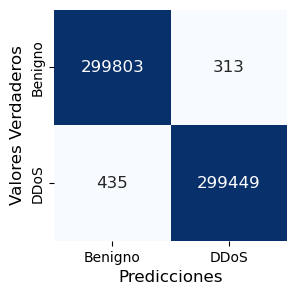

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# Asumiendo que 'matriz_confusion' es tu matriz de confusión calculada previamente

# Definir los nombres de las clases
class_names = ["Benigno", "DDoS"]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(3, 3))  # Ajustar el tamaño del gráfico
sns.heatmap(matriz_confusion, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})  # Ajustar el tamaño de la fuente

# Añadir etiquetas y título para mayor claridad
plt.xlabel('Predicciones', fontsize=12)  # Ajustar el tamaño de la fuente
plt.ylabel('Valores Verdaderos', fontsize=12)  # Ajustar el tamaño de la fuente
#plt.title('Matriz de Confusión', fontsize=12)  # Ajustar el tamaño de la fuente
plt.show()

